# Clustering Null Targets

Many assays do not have a protein target and theres no way to automatic group them..

To circumvent this, we can cluster the assays without targets.

In [2]:
import pandas as pd
import config
import seaborn as sns
import numpy as np
from curvep import curveP, CONCLIST
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau


sns.set(style="ticks", context="talk")
plt.style.use("dark_background")



In [3]:
# get all the targets in the database

q = "select PUBCHEM_AID from targets WHERE GeneSymbol IS NULL"

target_list = pd.read_sql_query(q, con=config.Config.DB_URI)
target_list.head()

,PUBCHEM_AID
0,679
1,691
2,721
3,790
4,801


In [5]:
target_list.PUBCHEM_AID.nunique()

1780

In [6]:
aid_list = [str(aid)for aid in target_list.PUBCHEM_AID.unique()]

aid_string = ", ".join(map(str, aid_list))
aid_query = f'({aid_string})'

actives_query = 'SELECT c.PUBCHEM_CID as CID, c.PUBCHEM_AID as AID, c.PUBCHEM_SID as SID ' \
                'FROM concise c ' \
                'WHERE c.PUBCHEM_AID in {} AND c.PUBCHEM_ACTIVITY_OUTCOME == "Active" AND ' \
                'c.PUBCHEM_CID is not null AND c.PUBCHEM_SID is not null'.format(aid_query)

active_cmps = pd.read_sql_query(actives_query, con=config.Config.DB_URI)
active_cmps['SID'] = active_cmps['SID'].astype(int)


In [7]:
sid_list = [str(sid)for sid in active_cmps.SID]

sid_string = ", ".join(map(str, sid_list))
sid_query = f'({sid_string})'

hill_params_query = 'SELECT  SID, AID, AC50, TOP, SLOPE, MSE ' \
                    'FROM hill_models ' \
                    'WHERE AID in {} AND SID in {} '.format(aid_query, sid_query)

hill_params = pd.read_sql_query(hill_params_query, con=config.Config.DB_URI)

# this merge is necessary because
# the former query gathers all data
# for all sid and aid that have any active cmps
# not just the pairs of active sid, aid
# could be solved by a SQLite join, but
# right now takes too long
hill_merged = pd.merge(hill_params, active_cmps[['SID', 'CID', 'AID']].drop_duplicates(['SID', 'CID', 'AID']), on=['SID', 'AID'])
print(hill_merged.head())


       SID  AID          AC50    TOP    SLOPE       MSE      CID
0   849441  679  3.467260e-07 -100.0  0.66502  0.014822   651936
1  4258988  679  3.467260e-07 -100.0  0.66502  0.014822  2201551
2  4260130  679  3.467260e-07 -100.0  0.66502  0.014822  1121645
3  4262073  679  3.467260e-07 -100.0  0.66502  0.014822  1307930
4  4264740  679  3.467260e-07 -100.0  0.66502  0.014822   912604


In [8]:
hill_merged = hill_merged.dropna()
hill_merged_trim = hill_merged[hill_merged.MSE < 500]
hill_merged_trim.shape

(375957, 7)

In [10]:
cid_avg = hill_merged_trim.groupby(['CID', 'AID'])['AC50'].mean().reset_index()
cid_avg.head()

,CID,AID,AC50
0,6,449748,4.463481
1,6,463074,5.164316
2,6,504832,24.482201
3,6,588856,8.313627
4,6,651633,45.959952


In [11]:
ac50s = cid_avg.pivot(index='CID', columns='AID', values='AC50')
ac50s

AID,679,721,790,826,846,875,886,890,892,893,...,1508630,1508637,1508638,1508639,1508641,1508642,1508645,1508648,1645845,1671193
CID,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
138402869,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.883353,NaN
139593605,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
146170498,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
ac50s_log = ac50s.applymap(lambda x: np.log10(x) if not np.isnan(x) else x)
ac50s_log.head()

AID,679,721,790,826,846,875,886,890,892,893,...,1508630,1508637,1508638,1508639,1508641,1508642,1508645,1508648,1645845,1671193
CID,,,,,,,,,,,,,,,,,,,,,
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
66,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
86,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
109,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
m = ac50s_log.corr()

KeyboardInterrupt: 

In [22]:
ac50s_log = ac50s_log.loc[:, ac50s_log.notnull().sum() > 50]
ac50s_log.shape

(148957, 487)

In [24]:
ac50s_log = ac50s_log[ac50s_log.notnull().any(1)]
ac50s_log.shape

(145735, 487)

In [26]:
m = ac50s_log.corr()

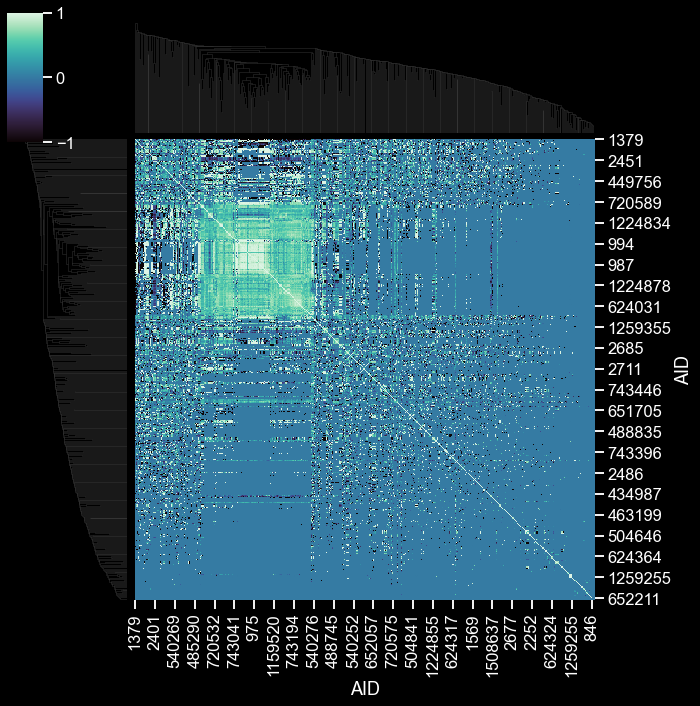

In [35]:
sns.clustermap(m.fillna(0), cmap="mako")

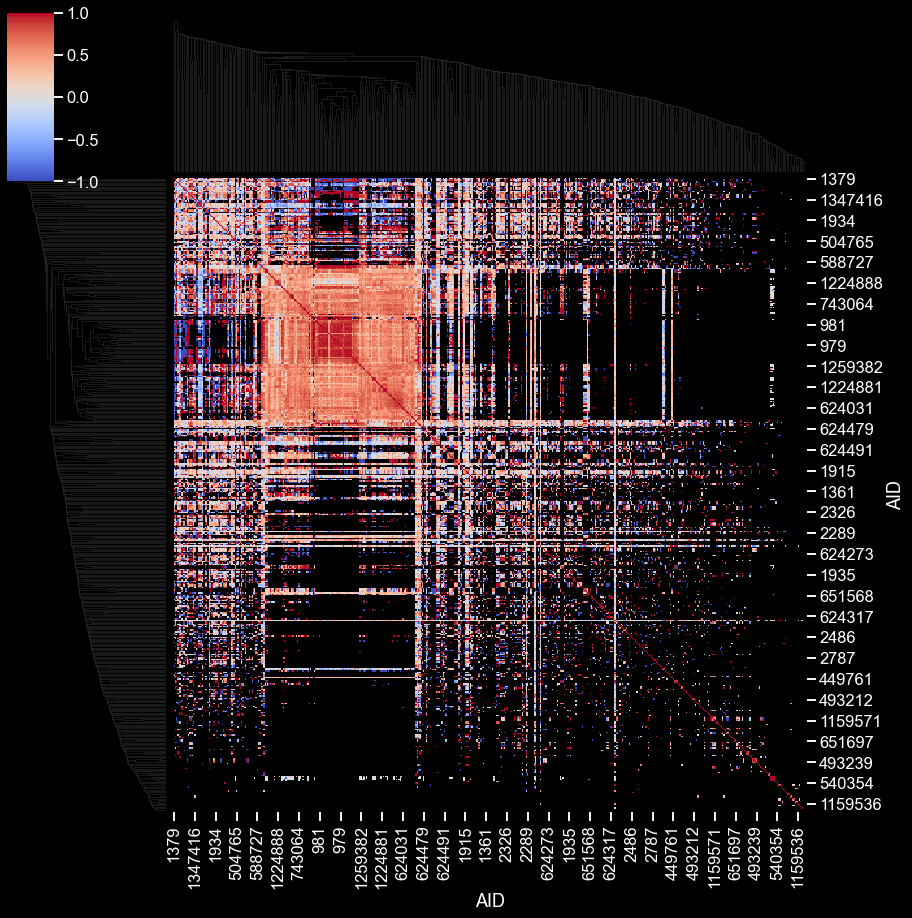

In [37]:
from scipy.spatial import distance
from scipy.cluster import hierarchy

correlations_array = np.asarray(m.fillna(0))

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

sns.clustermap(m, row_linkage=row_linkage, col_linkage=col_linkage, method="average", figsize=(13, 13), cmap='coolwarm')

In [38]:
col_linkage

array([[  9.        , 219.        ,   0.        ,   2.        ],
       [306.        , 487.        ,   0.        ,   3.        ],
       [314.        , 318.        ,   0.        ,   2.        ],
       ...,
       [380.        , 969.        ,  13.55805226, 485.        ],
       [378.        , 970.        ,  13.80082201, 486.        ],
       [ 43.        , 971.        ,  14.76684349, 487.        ]])

<AxesSubplot:ylabel='Count'>

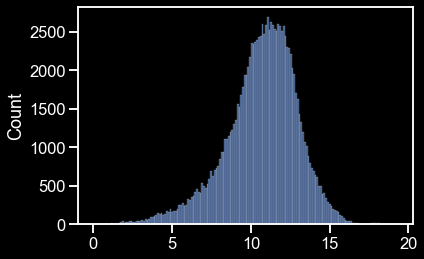

In [43]:
sns.histplot(distance.pdist(correlations_array))

In [72]:
import scipy.cluster.hierarchy as sch


clusters = pd.DataFrame(sch.fcluster(col_linkage, t=1)).reset_index()
clusters.nunique()

index    487
0        296
dtype: int64

In [80]:
counts = clusters.groupby(0)['index'].nunique().sort_values(ascending=False)
counts


0
95     38
20      9
28      8
42      7
34      7
       ..
198     1
199     1
200     1
201     1
148     1
Name: index, Length: 296, dtype: int64

In [81]:
m.columns[clusters[clusters[0] == 10].index]

Int64Index([1988, 1990, 1994, 489041], dtype='int64', name='AID')

In [61]:
m.loc[[449748, 463074],  [449748, 463074]]

AID,449748,463074
AID,,
449748,1.000000,0.603937
463074,0.603937,1.000000


In [82]:
q = "select * from bioassays"

bioassays = pd.read_sql_query(q, con=config.Config.DB_URI)

In [83]:
bioassays.head()

,index,AID,BioAssay Name,Deposit Date,Modify Date,Source Name,Source ID,Substance Type,Outcome Type,Project Category,BioAssay Group,BioAssay Types,Protein Accessions,UniProts IDs,Gene IDs,Target TaxIDs,Taxonomy IDs
0,0,1,NCI human tumor cell line growth inhibition as...,20040815,20220122,DTP/NCI,NCI human tumor cell line growth inhibition as...,small-molecule,Confirmatory,Other,None,None,None,None,None,NaN,None
1,1,3,NCI human tumor cell line growth inhibition as...,20040815,20220124,DTP/NCI,NCI human tumor cell line growth inhibition as...,small-molecule,Confirmatory,Other,None,None,None,None,None,NaN,None
2,2,5,NCI human tumor cell line growth inhibition as...,20040815,20220124,DTP/NCI,NCI human tumor cell line growth inhibition as...,small-molecule,Confirmatory,Other,None,None,None,None,None,NaN,None
3,3,7,NCI human tumor cell line growth inhibition as...,20040815,20220124,DTP/NCI,NCI human tumor cell line growth inhibition as...,small-molecule,Confirmatory,Other,None,None,None,None,None,NaN,None
4,4,9,NCI human tumor cell line growth inhibition as...,20040815,20220124,DTP/NCI,NCI human tumor cell line growth inhibition as...,small-molecule,Confirmatory,Other,None,None,None,None,None,NaN,None


In [85]:
b = bioassays[bioassays.AID.isin(m.columns)]

In [86]:
b.head()

,index,AID,BioAssay Name,Deposit Date,Modify Date,Source Name,Source ID,Substance Type,Outcome Type,Project Category,BioAssay Group,BioAssay Types,Protein Accessions,UniProts IDs,Gene IDs,Target TaxIDs,Taxonomy IDs
571,571,790,Screening for Modulators of Post-Golgi Transpo...,20070820,20080212,SRMLSC,Post-Golgi Vps1 DR Sec,small-molecule,Confirmatory,Molecular Libraries Screening Center Network,None,None,None,None,None,NaN,None
627,627,846,Factor XIa 1536 HTS Dose Response Confirmation,20071115,20081114,PCMD,FXIa_1536_DR,small-molecule,Confirmatory,Molecular Libraries Screening Center Network,None,None,AAA51985,None,None,NaN,9606
665,665,886,qHTS Assay for Inhibitors of HADH2 (Hydroxyacy...,20071216,20100712,National Center for Advancing Translational Sc...,HADH560,small-molecule,Confirmatory,Molecular Libraries Screening Center Network,None,None,2O23_A|2O23_B,Q99714|Q99714,None,NaN,9606
672,672,893,"qHTS Assay for Inhibitors of HSD17B4, hydroxys...",20071217,20100706,National Center for Advancing Translational Sc...,HSDB130,small-molecule,Confirmatory,Molecular Libraries Screening Center Network,None,None,2O23_A|2O23_B,Q99714|Q99714,None,NaN,9606
691,691,912,qHTS Assay for Anthrax Lethal Toxin Internaliz...,20071219,20100712,National Center for Advancing Translational Sc...,ANTX642,small-molecule,Confirmatory,Molecular Libraries Screening Center Network,None,None,NP_652928,None,None,NaN,191218


In [95]:
human_aids = b[b['Taxonomy IDs'] == '9606'].AID

In [99]:
sm = m.loc[human_aids.values, human_aids.values]

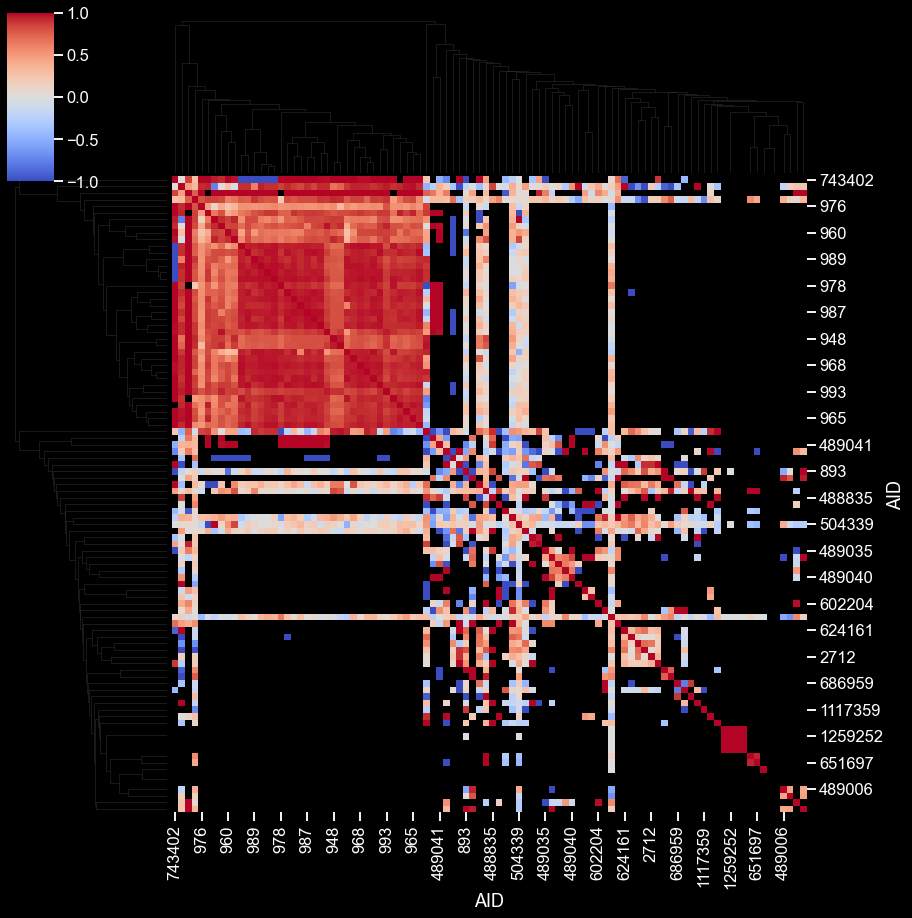

In [100]:

correlations_array = np.asarray(sm.fillna(0))

row_linkage = hierarchy.linkage(
    distance.pdist(correlations_array), method='average')

col_linkage = hierarchy.linkage(
    distance.pdist(correlations_array.T), method='average')

sns.clustermap(sm, row_linkage=row_linkage, col_linkage=col_linkage, method="average", figsize=(13, 13), cmap='coolwarm')

In [105]:
clusters = pd.DataFrame(sch.fcluster(col_linkage, t=1)).reset_index()
clusters.nunique()

index    96
0        40
dtype: int64

In [102]:
counts = clusters.groupby(0)['index'].nunique().sort_values(ascending=False)
counts

0
24    22
7     14
18     5
1      4
3      4
4      3
19     3
2      2
5      2
6      2
15     2
16     2
17     2
21     2
20     2
25     1
12     1
38     1
37     1
36     1
35     1
34     1
33     1
8      1
9      1
10     1
11     1
13     1
26     1
14     1
32     1
31     1
30     1
29     1
28     1
39     1
27     1
22     1
23     1
40     1
Name: index, dtype: int64

In [109]:
b.set_index('AID').loc[sm.columns[clusters[clusters[0] == 24].index]]

,index,BioAssay Name,Deposit Date,Modify Date,Source Name,Source ID,Substance Type,Outcome Type,Project Category,BioAssay Group,BioAssay Types,Protein Accessions,UniProts IDs,Gene IDs,Target TaxIDs,Taxonomy IDs
AID,,,,,,,,,,,,,,,,
846,627,Factor XIa 1536 HTS Dose Response Confirmation,20071115,20081114,PCMD,FXIa_1536_DR,small-molecule,Confirmatory,Molecular Libraries Screening Center Network,None,None,AAA51985,None,None,NaN,9606
2572,2326,Confirmation qHTS Assay for Inhibitors of the ...,20100316,20100316,National Center for Advancing Translational Sc...,APE1918,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,1DE9_A,P27695,None,NaN,9606
2677,2431,Confirmation qHTS Assay for Inhibitors of Hum...,20100325,20100325,National Center for Advancing Translational Sc...,JMJD280,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,2W2I_A,B2RXH2,None,NaN,9606
449754,449016,Luminescence Cell-Based Counterscreen to Ident...,20100716,20100719,Broad Institute,2045-02_INHIBITORS_DOSE-TITRATION_MLPCN-CHERRY...,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,Cell-based,2VM6_A,Q16548,None,NaN,9606
489006,487688,Dose Response selectivity of uHTS chemical inh...,20101115,20101201,Burnham Center for Chemical Genomics,SBCCG-A521-NFkB-Jurkat-DR-B-Assay,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,None,None,None,NaN,9606
489020,487702,Dose response counterscreen of uHTS chemical i...,20101118,20101202,Burnham Center for Chemical Genomics,SBCCG-A526-NFkB-TNFa-DR-BT-Counterscreen-Assay,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,None,None,None,NaN,9606
489022,487704,Dose response counterscreen of uHTS chemical i...,20101118,20101203,Burnham Center for Chemical Genomics,SBCCG-A527-NFkB-TNFa-DR-B-Counterscreen-Assay,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,None,None,None,NaN,9606
489023,487705,Dose response confirmation of uHTS of chemical...,20101118,20101118,Burnham Center for Chemical Genomics,SBCCG-A518-NFkB-697B-DR-B-Assay,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,None,None,None,NaN,9606
493212,491794,Inhibitors of Human Jumonji Domain Containing ...,20110214,20110214,National Center for Advancing Translational Sc...,JMJD233,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,2W2I_A,B2RXH2,None,NaN,9606


In [112]:
sm.iloc[clusters[clusters[0] == 24].index]

AID,846,886,893,921,946,948,960,961,963,964,...,686960,686971,720499,720535,743402,1117359,1259252,1259253,1259255,1259256
AID,,,,,,,,,,,,,,,,,,,,,
846,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2572,NaN,0.279841,0.132949,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-0.161521,-0.999855,NaN,-0.436969,-1.0,NaN,NaN,NaN,NaN
2677,NaN,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.573185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
449754,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.095996,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
489006,NaN,NaN,-0.536272,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.380260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
489020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.269030,NaN,0.110827,NaN,NaN,NaN,NaN,NaN,NaN
489022,NaN,NaN,0.999543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.348949,NaN,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
489023,NaN,NaN,0.023713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.140144,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
493212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.755642,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [110]:
b['UniProts IDs'].value_counts()

P27695           3
P46063           3
B2RXH2           3
P02791           2
P00811           2
Q9NUW8           2
Q99714|Q99714    2
P10520           2
Q16548           2
O75164           1
P00761           1
P29991           1
P03070           1
Name: UniProts IDs, dtype: int64

In [111]:
b[b['UniProts IDs'] == 'P27695']

,index,AID,BioAssay Name,Deposit Date,Modify Date,Source Name,Source ID,Substance Type,Outcome Type,Project Category,BioAssay Group,BioAssay Types,Protein Accessions,UniProts IDs,Gene IDs,Target TaxIDs,Taxonomy IDs
1476,1476,1705,qHTS Validation Assay for Inhibitors of the Hu...,20090430,20090505,National Center for Advancing Translational Sc...,APE1734,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,1DE9_A,P27695,None,NaN,9606
2272,2272,2517,qHTS Assay for Inhibitors of the Human Apurini...,20100311,20130716,National Center for Advancing Translational Sc...,APE1917,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,1DE9_A,P27695,None,NaN,9606
2326,2326,2572,Confirmation qHTS Assay for Inhibitors of the ...,20100316,20100316,National Center for Advancing Translational Sc...,APE1918,small-molecule,Confirmatory,Molecular Libraries Probe Production Centers N...,None,None,1DE9_A,P27695,None,NaN,9606
